In [1]:
import scipy
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import numpy
import pandas
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import tensorflow

import math
import random
import os
import time
import csv
import functools

import ee

In [2]:
# File path to the simulated data to train the neural network with, relative to the file location of the script
mat_file_path = "data/s2_sl2p_weiss_or_prosail_inout.mat"
variables_to_load = ["Input", "Output"]

In [3]:
# Load matlab data into dictionary mapping the variable_names to arrays containing their values
matlab_data = sio.loadmat(file_name=mat_file_path, variable_names=variables_to_load)

In [4]:
# Load the simulated reflectances and the angles into dataframes
input_reflectances = pandas.DataFrame(data=matlab_data['Input']['Rho_Toc'][0][0])
input_angles = pandas.DataFrame(data=matlab_data['Input']['Angles'][0][0])

# Format the dataframe to contain the correct column labels with all of the input data
inputs = pandas.concat([input_reflectances, input_angles], axis=1, ignore_index=True)
inputs = pandas.DataFrame(inputs)
bands = ['B4', 'B5', 'B6', 'B7', 'B8A', 'B9', 'B11', 'B12']
angles = ['SZA', 'SAA', 'ALT']
features = bands + angles
inputs.columns = features

In [199]:
output_var = "LAI"

In [200]:
# Extract the outputs from the matlab_data dictionary into pandas series
LAI = pandas.Series(data=matlab_data['Output']['LAI'][0][0].flatten(), name="LAI")
FAPAR = pandas.Series(data=matlab_data['Output']['FAPAR'][0][0].flatten(), name="FAPAR")
FCOVER = pandas.Series(data=matlab_data['Output']['FCOVER'][0][0].flatten(), name="FCOVER")

outputs = pandas.concat([LAI, FAPAR, FCOVER], axis=1)[output_var]

In [6]:
num_samples = inputs.shape[0]
num_features = inputs.shape[1]

In [7]:
# Number of batches the user wishes to split the data into to be clustered by K-means clustering
# Should eventually be specifiable by the user
num_batches = 100

# Sets the number of clusters to a minimum of 100, or higher if the user requests more based on the number of samples
num_clusters = max(100, num_samples/(num_batches*1000))

In [8]:
# Cluster the input data using euclidean distances between data points (not currently possible to specify other distance metrics)
# Getting the labels for each of the points used to fit the KMeans clusterer
sample_clusters = KMeans(n_clusters=num_clusters).fit(inputs).labels_

In [9]:
# Dataframe that stores all of the inputs and the outputs to cluster the inputs alongside their respective outputs using the cluster labels
input_data = inputs.join(LAI).join(FAPAR).join(FCOVER)

In [10]:
# Get a dictionary mapping the cluster number to the sample indices in that cluster
cluster_dictionary = input_data.groupby(sample_clusters).groups

The main goal of clustering the input data is so that during validation we do not just randomly sample validation data, or just sample a subset of the data in a specific range of the output values. Instead we can now force the model to extrapolate during validation by removing entire chunks of data (removing 20% of the clusters of data as opposed to 20% of the data randomly).

In [11]:
# A user specified validation split to use when training the model. 
validation_split = 0.2

# We can get the number of clusters we will have to remove from the full set of inputs for validation using the validation split
num_validation_clusters = int(math.ceil(num_clusters*validation_split))

In [12]:
# Randomly generate the numbers of the clusters we will use to create the validation dataset
validation_clusters = random.sample(range(0, num_clusters), num_validation_clusters)

In [13]:
# First create a list of pandas index objects containing the indices of the samples belonging to each cluster in the validation_clusters list
validation_samples = [cluster_dictionary[cluster] for cluster in validation_clusters]
# Use these indices to create a dataframe containing only validation samples
validation_data = pandas.concat([input_data.loc[cluster] for cluster in validation_samples], ignore_index=True)
num_validation_samples = len(validation_data)

In [14]:
# All of the clusters not in the validation_cluster list will be used for calibrating the nueral network
calibration_clusters = list(set(range(0, num_clusters)) - set(validation_clusters))
# Generate a dataframe containing only calibration samples using the same method as above
calibration_samples = [cluster_dictionary[cluster] for cluster in calibration_clusters]
calibration_data = pandas.concat([input_data.loc[cluster] for cluster in calibration_samples], ignore_index=True)
num_calibration_samples = len(calibration_data)

In [203]:
# Separate the features and the targets, also standaradize the features to a mean of 0 and standard deviation of 1
training_data = preprocessing.scale(calibration_data[features])
training_targets = calibration_data[output_var].values

In [205]:
# Create a tuple containing the input features (scaled) and the targets from the validation dataframe
validation_set = (preprocessing.scale(validation_data[features]), validation_data[output_var].values)

In [17]:
# Use the keras backend to define a custom activation function used in the SL2P neural network model
def tansig(x):
    return (2 / (1 + tensorflow.keras.backend.exp(-2*x)) ) - 1

In [18]:
# Add this function as an activation function to this scripts custom keras objects for easier use in models
tensorflow.keras.utils.get_custom_objects()['tansig'] = tensorflow.keras.layers.Activation(tansig)

In [19]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
# The below model closely follows the SL2P neural network architecture as described
SL2P_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(11, input_shape = [num_features]),
    tensorflow.keras.layers.Dense(5, activation='tansig'),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
SL2P_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse')

In [20]:
# Create a callback for early stopping the model (prevent the model from overfitting) by stopping the training when the mean squared error on the validation dataset does not improve over 25 epochs
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=25, verbose=0, mode="min", restore_best_weights=True)
# Training the model on the training data, validating on the validation data
SL2P_model.fit(x=training_data, y=training_targets, batch_size=32, epochs=1000, verbose=1, callbacks=[early_stopping], shuffle=True, validation_data=validation_set)

Train on 33280 samples, validate on 8192 samples
Epoch 1/1000
33280/33280 [==============================] - 2s 58us/sample - loss: 3.3639 - val_loss: 1.5177
Epoch 2/1000
33280/33280 [==============================] - 1s 37us/sample - loss: 0.9215 - val_loss: 0.8948
Epoch 3/1000
33280/33280 [==============================] - 1s 37us/sample - loss: 0.5527 - val_loss: 0.6976
Epoch 4/1000
33280/33280 [==============================] - 1s 37us/sample - loss: 0.4228 - val_loss: 0.5037
Epoch 5/1000
33280/33280 [==============================] - 1s 39us/sample - loss: 0.3725 - val_loss: 0.4428
Epoch 6/1000
33280/33280 [==============================] - 1s 41us/sample - loss: 0.3421 - val_loss: 0.4579
Epoch 7/1000
33280/33280 [==============================] - 1s 40us/sample - loss: 0.3192 - val_loss: 0.4119
Epoch 8/1000
33280/33280 [==============================] - 1s 38us/sample - loss: 0.3023 - val_loss: 0.4014
Epoch 9/1000
33280/33280 [==============================] - 1s 37us/sample - lo

The code below is the exact same code as in the previous several cells, however, the implementation of the loop and the generation of a randomly subsampled set of validation data (and calibration data) in each loop, where in each loop the model is subsequently trained on the calibration data and validated on the validation data. This is a form of Monte-Carlo cross-validation applied to training our neural network.

In [21]:
validation_split = 0.2
num_validation_clusters = int(math.ceil(num_clusters*validation_split))
num_cv_loops = 50
num_epochs_per_loop = 20

for loop in range(num_cv_loops):
    
    validation_clusters = random.sample(range(0, num_clusters), num_validation_clusters)
    validation_dictionary = {cluster : cluster_dictionary[cluster] for cluster in validation_clusters}
    validation_data = pandas.concat([input_data.loc[cluster] for cluster in validation_dictionary.values()], ignore_index=True)
    num_validation_samples = len(validation_data)
    
    calibration_clusters = list(set(range(0, num_clusters)) - set(validation_clusters))
    calibration_dictionary = {cluster : cluster_dictionary[cluster] for cluster in calibration_clusters}
    calibration_data = pandas.concat([input_data.loc[cluster] for cluster in calibration_dictionary.values()], ignore_index=True)
    num_calibration_samples = len(calibration_data)
    
    training_data = preprocessing.scale(calibration_data[features])
    training_targets = calibration_data[output_var].values
    
    validation_set = (preprocessing.scale(validation_data[features]), validation_data[output_var].values)

    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10, verbose=0, mode="min", restore_best_weights=True)
    SL2P_model.fit(x=training_data, y=training_targets, batch_size=32, epochs=num_epochs_per_loop, verbose=0, callbacks=[early_stopping], shuffle=True, validation_data=validation_set)

In [22]:
# Scale the full set of inputs for prediction
scaled_inputs = preprocessing.scale(inputs)

In [23]:
# Predicting our own input data to evaluate the performance (for now)
nnet_predictions = SL2P_model.predict(scaled_inputs).flatten()

In [217]:
# Stacks the arrays (true values and predicted values) into a 2d array
stacked_data_nnet = numpy.vstack([outputs.values, nnet_predictions])

In [218]:
# Get the density of the data at each sample point
density_data_nnet = stats.gaussian_kde(stacked_data_nnet)(stacked_data_nnet)

In [219]:
# Reorder the data to be plotted so higher density points are plotted on top
density_sort_order_nnet = density_data_nnet.argsort()
x_nnet = outputs[density_sort_order_nnet]
y_nnet = nnet_predictions[density_sort_order_nnet]
c_nnet = density_data_nnet[density_sort_order_nnet]

In [220]:
# Calculate the RMSE of the model
rmse_nnet = metrics.mean_squared_error(x_nnet, y_nnet, squared=False)

In [227]:
# Using matplotlib to plot the predictions against the true values, with a line showing the ideal behaviour of any model
ideal_predictor_nnet = numpy.linspace(0, 12, 1000)

Text(0.5, 1.0, 'Neural Net LAI prediction - RMSE: 0.4316116042759724')

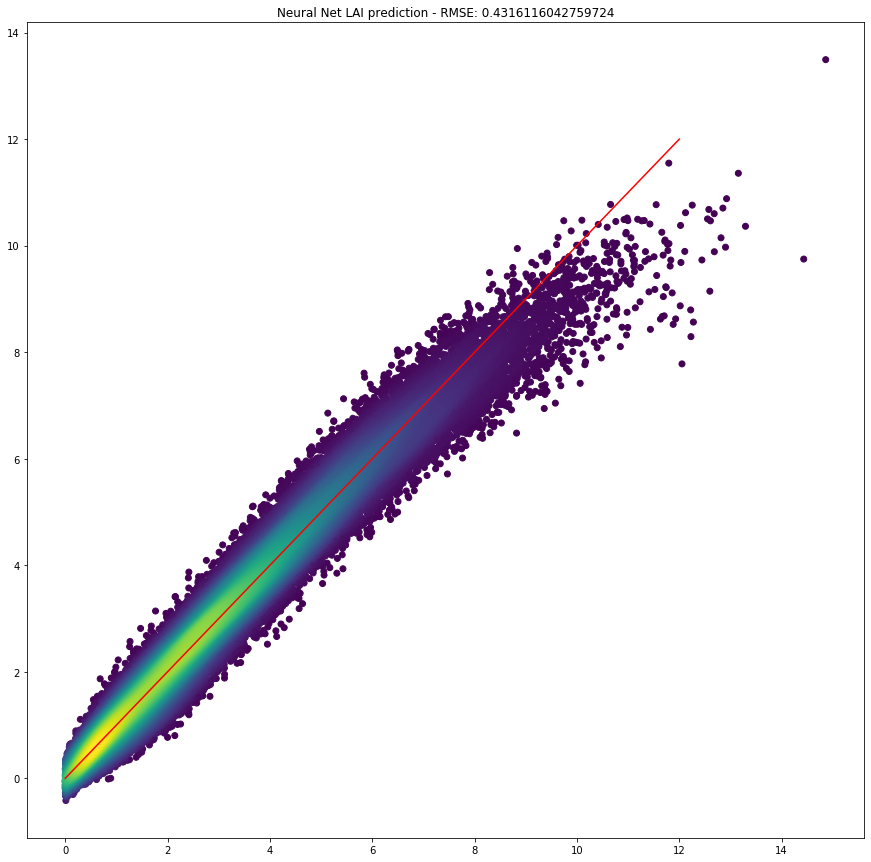

In [228]:
fig_nnet, ax_nnet = plt.subplots(1, 1, figsize=(15,15))

ax_nnet.scatter(x_nnet, y_nnet, c=c_nnet)
ax_nnet.plot(ideal_predictor_nnet, ideal_predictor_nnet, c='r')
ax_nnet.set_title(("Neural Net "+output_var+" prediction - RMSE: {}").format(rmse_nnet))

In [216]:
# Using scikit-learns implementation of Random Forest regression, fit a random forest to our input data
rf_model = RandomForestRegressor()
rf_model.fit(scaled_inputs, outputs.values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
rf_predictions = rf_model.predict(scaled_inputs)

In [223]:
stacked_data_rf = numpy.vstack([outputs.values, rf_predictions])

In [224]:
density_data_rf = stats.gaussian_kde(stacked_data_rf)(stacked_data_rf)

In [225]:
density_sort_order_rf = density_data_rf.argsort()
x_rf = outputs[density_sort_order_rf]
y_rf = rf_predictions[density_sort_order_rf]
c_rf = density_data_rf[density_sort_order_rf]

In [226]:
rmse_rf = metrics.mean_squared_error(x_rf, y_rf, squared=False)

In [229]:
ideal_predictor_rf = numpy.linspace(0, 14, 1000)

Text(0.5, 1.0, 'Random Forest LAI prediction - RMSE: 0.23553391152953776')

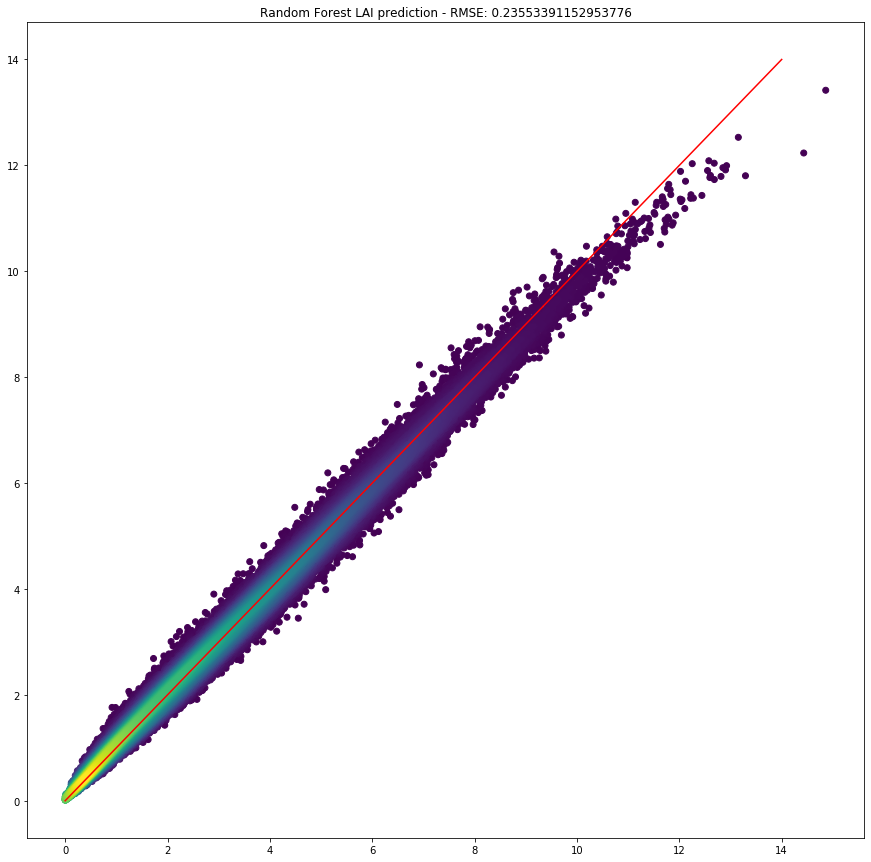

In [231]:
fig_rf, ax_rf = plt.subplots(1, 1, figsize=(15,15))

ax_rf.scatter(x_rf, y_rf, c=c_rf)
ax_rf.plot(ideal_predictor_rf, ideal_predictor_rf, c='r')
ax_rf.set_title(("Random Forest "+output_var+" prediction - RMSE: {}").format(rmse_rf))

In [232]:
prediction_dataset = inputs.join(outputs).join(pandas.Series(nnet_predictions, name="NNET"))

In [37]:
band_measurement_error = pandas.Series([0.025]*num_features, name="error")
band_measurement_error.index = features

In [234]:
const_frame = pandas.DataFrame(True, index=range(0,num_samples), columns=[output_var, "NNET"])
def average_RMSE(sample):
    samples = sample[1].loc[features]

    range_min = samples.sub(band_measurement_error)
    range_max = samples.add(band_measurement_error)

    indistinguishable = prediction_dataset[((inputs >= range_min) & (inputs <= range_max)).join(const_frame)].dropna()

    num_indistinguishable = len(indistinguishable)
    true_values = indistinguishable[output_var]
    predictions = indistinguishable.NNET

    RMSE = (predictions.sub(true_values).pow(2).sum()/num_indistinguishable) ** 0.5
    return RMSE

In [235]:
RMSE_test = list(map(average_RMSE, prediction_dataset.iterrows()))

In [237]:
RMSE = numpy.asarray(RMSE_test)

In [40]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
SL2P_error_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(11, input_shape = [num_features]),
    tensorflow.keras.layers.Dense(5, activation='tansig'),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
SL2P_error_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse')

In [41]:
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001, patience=25, verbose=1, mode="min", restore_best_weights=True)
SL2P_error_model.fit(x=scaled_inputs, y=RMSE, batch_size=32, epochs=1000, verbose=1, callbacks=[early_stopping], shuffle=True)

Train on 41472 samples
Epoch 1/1000
41472/41472 [==============================] - 2s 49us/sample - loss: 0.0520
Epoch 2/1000
41472/41472 [==============================] - 1s 30us/sample - loss: 0.0378
Epoch 3/1000
41472/41472 [==============================] - 1s 30us/sample - loss: 0.0369
Epoch 4/1000
41472/41472 [==============================] - 1s 31us/sample - loss: 0.0365
Epoch 5/1000
41472/41472 [==============================] - 1s 33us/sample - loss: 0.0364
Epoch 6/1000
41472/41472 [==============================] - 1s 33us/sample - loss: 0.0362
Epoch 7/1000
41472/41472 [==============================] - 1s 32us/sample - loss: 0.0360
Epoch 8/1000
41472/41472 [==============================] - 1s 32us/sample - loss: 0.0358
Epoch 9/1000
41472/41472 [==============================] - 1s 33us/sample - loss: 0.0357
Epoch 10/1000
41472/41472 [==============================] - 1s 33us/sample - loss: 0.0356
Epoch 11/1000
41472/41472 [==============================] - 1s 34us/sample 

In [42]:
# Predicting our own input data to evaluate the performance (for now)
nnet_error_predictions = SL2P_error_model.predict(scaled_inputs).flatten()

In [238]:
stacked_data_error = numpy.vstack([RMSE, nnet_error_predictions])

In [239]:
density_data_error = stats.gaussian_kde(stacked_data_error)(stacked_data_error)

In [244]:
density_sort_order_error = density_data_error.argsort()
x_error = RMSE[density_sort_order_error]
y_error = nnet_error_predictions[density_sort_order_error]
c_error = density_data_error[density_sort_order_error]

In [245]:
rmse_error = metrics.mean_squared_error(x_error, y_error, squared=False)

In [251]:
ideal_predictor_error = numpy.linspace(0, 4, 1000)

Text(0.5, 1.0, 'Neural Net LAI Error prediction - RMSE: 0.18510873299267214')

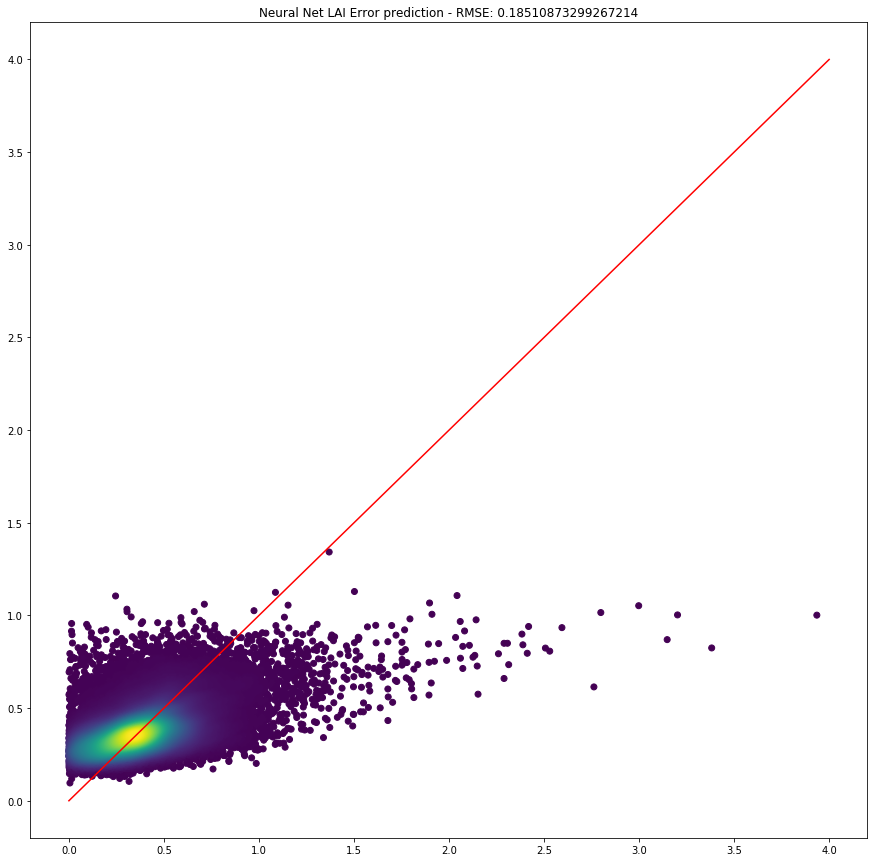

In [252]:
fig_error, ax_error = plt.subplots(1, 1, figsize=(15,15))

ax_error.scatter(x_error, y_error, c=c_error)
ax_error.plot(ideal_predictor_error, ideal_predictor_error, c='r')
ax_error.set_title(("Neural Net "+output_var+" Error prediction - RMSE: {}").format(rmse_error))

In [48]:
# The following function exports the keras model in a way that can be parsed into a feature collection in Earth Engine and applied to images manually
def export_nnet(keras_model, csv_file_name: str = "nnet"):
    headers = []
    prev_layer_size = len(features)
    nnet_data = [[1, 1, 0, None, prev_layer_size, ','.join(features)]]
    layer_num = 1
    
    for layer in keras_model.layers:
        layer_info = layer.get_config()
        num_nodes = layer_info["units"]
        activation = layer_info["activation"]
        if isinstance(activation, dict):
            activation = activation["config"]["activation"]
        
        layer_weights = layer.get_weights()[0]
        layer_bias = layer.get_weights()[1]

        headers = list(set(headers) | set([x+1 for x in range((prev_layer_size+1)*num_nodes)]))

        layer_data = [0, 0, layer_num, prev_layer_size, num_nodes, activation] + layer_weights.flatten().tolist() + layer_bias.tolist()
        nnet_data.append(layer_data)

        prev_layer_size = num_nodes
        layer_num += 1
    
    nnet_data.insert(0, ["latitude", "longitude", "layer_num", "prev_layer_size", "num_nodes", "activation"]+headers)
    
    file_name = csv_file_name + ".csv"
    with open(file_name, 'w', newline='') as csvfile:
        nnet_writer = csv.writer(csvfile)
        for layerdata in nnet_data:
            nnet_writer.writerow(layerdata)
            
    return

In [49]:
export_nnet(SL2P_model, "SL2P")
export_nnet(SL2P_error_model, "SL2P_error")

In [50]:
# Authorizes the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Initialize()

In [52]:
nnet = ee.FeatureCollection("users/ccrs2fy2020/SL2P")
nnet_inputs = nnet.filter(ee.Filter.eq("layer_num", 0)).first()
num_inputs = nnet_inputs.getNumber("num_nodes")

selected_features = nnet_inputs.getString("activation").split(",")

nnet = nnet.filterBounds(ee.Geometry.Point([0,0]))
layer_list = nnet.sort("layer_num").toList(nnet.size())


def parse_layer(feature):
    feature = ee.Feature(feature)
    prev_layer_size = feature.getNumber("prev_layer_size")
    num_nodes = feature.getNumber("num_nodes")
    node_size = prev_layer_size.subtract(1)
    activation = feature.getString("activation")
    
    return ee.ImageCollection(ee.List.sequence(1, num_nodes).map(lambda node: ee.ImageCollection(
                        ee.List.sequence(ee.Number(node).toInt(), ee.Number(node).toInt().add(node_size.multiply(num_nodes)), num_nodes)
                        .map(lambda index: ee.Image(feature.getNumber(ee.Number(index).toInt().format())))).toBands().set(
                            {"bias": feature.getNumber(ee.Number(node).toInt().add(prev_layer_size.multiply(num_nodes)).toInt().format())}))).set({"activation": activation})

neural_net = layer_list.map(parse_layer)


collection = "COPERNICUS/S2_SR"

filter_start_date = ee.Date('2019-06-01')
filter_end_date = ee.Date('2019-06-30')

filter_bounds = ee.Geometry.Polygon([[[-98.16463919070031, 49.56174013736053],
                                      [-97.74988035545425, 49.55800280566425],
                                      [-97.74288559251306, 49.8299316015145],
                                      [-98.15996345571678, 49.833705130736035]]])

max_cloud_cover = 90

input_collection = ee.ImageCollection(collection) \
                        .filterBounds(filter_bounds) \
                        .filterDate(filter_start_date, filter_end_date) \
                        .filterMetadata("WATER_PERCENTAGE", "less_than", 100) \
                        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", max_cloud_cover) \
                        .select(bands)

def scale_image(image):
    image = ee.Image(image);

    image = image.addBands((image.metadata("MEAN_SOLAR_ZENITH_ANGLE").rename("SZA")).multiply(3.1415).divide(180).cos()) \
                .addBands((image.metadata("MEAN_SOLAR_AZIMUTH_ANGLE").rename("SAA")).multiply(3.1415).divide(180).cos()) \
                .addBands(ee.Image(1).rename("ALT"))

    # Setting up lists containing the input/feature bands in the image
    bandList = image.bandNames();
    num_bands = bandList.length();

    # Initial centering all of the input bands, added VIs, and response with the input image
    meanImage = image.subtract(
                image.reduceRegion(reducer=ee.Reducer.mean(), geometry=filter_bounds, bestEffort=True, maxPixels=10000000, tileScale=1)
                .toImage(bandList)
              );

    # Standardizing the input features
    standardImage = meanImage.divide(
                    meanImage.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=filter_bounds, bestEffort=True, maxPixels=10000000, tileScale=1)
                    .toImage(bandList)
                  );
  
    return standardImage

scaled_collection = ee.ImageCollection(input_collection.map(scale_image));


# Defining all of the activation functions for image structures in Earth Engine
def linear(x):
    return ee.Image(x)

def elu(x):
    return ee.ImageCollection([x.mask(x.gte(0)), x.mask(x.lt(0)).exp().subtract(1)]).mosaic()

def softplus(x):
    return x.exp().add(1).log()

def softsign(x):
    return x.divide(x.abs().add(1))

def relu(x):
    return x.max(0.0)

def tanh(x):
    return x.multiply(2).exp().subtract(1).divide(x.multiply(2).exp().add(1))

def sigmoid(x):
    return x.exp().pow(-1).add(1).pow(-1)

def tansig(x):
    return x.multiply(-2).exp().add(1).pow(-1).multiply(2).subtract(1)


# The following function applies a layer in the neural network as parsed in the parse_layer function to an input image with the selected features, and response.
# To fully apply the neural network we apply this function using the .iterate() method in Earth Engine on the input image in place of a loop
def apply_layer(layer, inputs):
    layer = ee.ImageCollection(layer)
    inputs = ee.Image(inputs)
    
    activation = layer.getString("activation")

    def apply_node(node):
        node = ee.Image(node)
        bias = node.getNumber("bias")
        
        # Multiply by the weights of the node and add the bias of the node
        result = inputs.multiply(node).reduce(ee.Reducer.sum()).add(bias)
        # For now we can only apply the softsign activation function if the activation property of the layer is not "linear"
        return ee.Algorithms.If(activation.compareTo("linear"), tansig(result), result)
    
    node_outputs = layer.map(apply_node).toBands()
    
    return node_outputs


def apply_nnet(image):
    image = ee.Image(image)
    return ee.Image(neural_net.iterate(apply_layer, image)).rename("LAI")

predicted_collection = scaled_collection.map(apply_nnet)

In [54]:
ee.Initialize()

In [55]:
# Wait loop for Earth Engine tasks to complete. Polls for the task status the specificed number of seconds until it is no longer active
def task_wait_loop(ee_task, wait_interval):
    print(ee.data.getTaskStatus(ee_task.id)[0]["description"]+":", end=" ")
    prev_task_status = ee.data.getTaskStatus(ee_task.id)[0]["state"]
    print(prev_task_status, end=" ")
    while ee_task.active():
        task_status = ee.data.getTaskStatus(ee_task.id)[0]["state"]
        if(task_status != prev_task_status):
            print(task_status, end=" ")
        prev_task_status = task_status
        time.sleep(wait_interval)
    print(ee.data.getTaskStatus(ee_task.id)[0]["state"])

In [56]:
def export_collection_to_gee(collection, asset_folder: str, scale: float = 1000, data_type: str = "float", num_images: int = 500, max_pixels: int = 1e8, refresh_time: int = 5):
    collection = ee.ImageCollection(collection)
    ee.ImageCollection(asset_folder).copyProperties(source=collection)
    
    num_images = collection.size().min(min(num_images, 5000))
    image_list = collection.toList(count = num_images)
    
    for i in range(num_images.getInfo()):
        image = ee.Image(image_list.get(i))
        name = image.id()
        
        typed_images = {"double": image.toDouble(), "float": image.toFloat(), "byte": image.toByte(), "int": image.toInt()}
        
        export_task = ee.batch.Export.image.toAsset(image = typed_images[data_type],
                                                      description = name.getInfo() ,
                                                      assetId = ee.String(asset_folder+"/").cat(name).getInfo(),
                                                      region = filter_bounds,
                                                      scale = scale,
                                                      maxPixels = max_pixels)
        export_task.start()
        # task_wait_loop(export_task, refresh_time)

In [57]:
def export_collection_to_drive(collection, gdrive_folder: str = "", scale: float = 1000, data_type: str = "float", num_images: int = 500, max_pixels: int = 1e8, refresh_time: int = 5):
    collection = ee.ImageCollection(collection)
    num_images = collection.size().min(min(num_images, 5000))
    
    image_list = collection.toList(count = num_images)
    
    for i in range(num_images.getInfo()):
        image = ee.Image(image_list.get(i))
        name = image.id()
        
        typed_images = {"double": image.toDouble(), "float": image.toFloat(), "byte": image.toByte(), "int": image.toInt()}
        
        export_task = ee.batch.Export.image.toDrive(image = typed_images[data_type],
                                                    description = name.getInfo(),
                                                    folder = gdrive_folder,
                                                    fileNamePrefix = name.getInfo(),
                                                    region = filter_bounds,
                                                    scale = scale,
                                                    maxPixels = max_pixels)
        export_task.start()
        # task_wait_loop(export_task, refresh_time)

In [58]:
def nnet_to_ee(keras_model):
    neural_net = ee.List([])
    for layer in keras_model.layers:
        layer_info = layer.get_config()
        num_nodes = layer_info["units"]
        activation = layer_info["activation"]
        if isinstance(activation, dict):
            activation = activation["config"]["activation"]
        
        layer_weights = layer.get_weights()[0].transpose()
        layer_bias = layer.get_weights()[1].tolist()
        
        nodes = [ee.ImageCollection([ee.Image(weight) for weight in node.tolist()]).toBands() for node in layer_weights]
        node_collection = ee.ImageCollection(ee.List([ee.Image(nodes[i]).set({"bias": layer_bias[i]}) for i in range(num_nodes)])).set({"activation": activation})
        neural_net = neural_net.add(node_collection)
    
    return neural_net

In [59]:
SL2P = nnet_to_ee(SL2P_model)
SL2P_error = nnet_to_ee(SL2P_error_model)

In [191]:
collection = "COPERNICUS/S2_SR"

filter_bounds = ee.Geometry.Polygon(
        [[[-98.16463919070031, 49.56174013736053],
          [-97.74988035545425, 49.55800280566425],
          [-97.74288559251306, 49.8299316015145],
          [-98.15996345571678, 49.833705130736035]]])

filter_start_date = ee.Date('2019-06-01')
filter_end_date = ee.Date('2019-06-30')

max_cloud_cover = 10

In [192]:
input_collection = ee.ImageCollection(collection).filterBounds(filter_bounds) \
                                                .filterDate(filter_start_date, filter_end_date) \
                                                .filterMetadata("WATER_PERCENTAGE", "less_than", 100) \
                                                .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", max_cloud_cover)

In [193]:
# Here the user would select a single image from the sentinel collection to process and run ALR on
# We have set our max cloud cover above such that this collection only contains one image from the time frame specified in the filters
input_image = input_collection.first()

In [194]:
sentinel_0001 = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]
sentinel_001 = ["AOT", "WVP"]
sentinel_bands = ["SCL", "TCI_R", "TCI_G", "TCI_B", "MSK_CLDPRB", "MSK_SNWPRB", "QA10", "QA20", "QA60"]

def format_sentinel_image(image):
    image = ee.Image(image)
    return image.select(sentinel_0001).multiply(0.0001) \
            .addBands(image.select(sentinel_001).multiply(0.001)) \
            .addBands(image.metadata("MEAN_SOLAR_ZENITH_ANGLE").rename("SZA").multiply(3.1415).divide(180).cos()) \
            .addBands(image.metadata("MEAN_SOLAR_AZIMUTH_ANGLE").rename("SAA").multiply(3.1415).divide(180).cos()) \
            .addBands(ee.Image(1).rename("ALT")) \
            .addBands(image.select(sentinel_bands)) \
            .clip(filter_bounds) \
            .copyProperties(source=image)

In [195]:
prepped_image = ee.Image(format_sentinel_image(input_image))

### Vegetation Indices Sources

1. https://www.hindawi.com/journals/js/2017/1353691/tab1/
2. https://www.hiphen-plant.com/blog/vegetation-indices/
3. https://gisgeography.com/sentinel-2-bands-combinations/

In [196]:
# Below we define a list of strings representing the expressions for each vegetation index as a function of the bands in the input image
# More vegetation indices can be defined, but the list CANNOT contain any two vegetation indices which are a linear combination of each
# other or LARs will fail to select the requested number of variables
# The formatting of the expression must be 
# "<name of VI> = <expression with band names from inputImage_bands used as variables in the form b('<band name>')"
input_VI_definition = ee.List(["GI      = b('B3')/b('B4')",
                              "RVI3    = b('B4')/b('B6')",
                              "SR3     = b('B5')/b('B4')",
                              "GM1     = b('B6')/b('B3')",
                              "GM2     = b('B6')/b('B5')",
                              "SR2     = b('B7')/b('B3')",
                              "PSSR    = b('B7')/b('B4')",
                              "SGI     = b('B8A')/b('B4')",
                              "MSI     = b('B11')/b('B7')",
                              "II      = b('B11')/b('B12')",
                              "GVI     = (b('B8A')/b('B3'))-1",
                              "PSRI    = (b('B4')-b('B3'))/b('B6')",
                              "NDVI3   = ((b('B8A')-b('B4'))/(b('B8A')))+b('B4')",
                              "SR5     = 1/b('B5')",
                              "SR6     = b('B4')/(b('B3')*b('B5'))",
                              "SR7     = b('B8A')/(b('B3')*b('B5'))",
                              "IPVI    = b('B7')/(b('B7')+b('B4'))",
                              "ARI     = (1/b('B3'))-(1/b('B5'))",
                              "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                              "NDVI    = (b('B8A')-b('B4'))/(b('B8A')+b('B4'))",
                              "GNDVI   = (b('B8A')-b('B3'))/(b('B8A')+b('B3'))",
                              "NDWI    = (b('B8A')-b('B11'))/(b('B8A')+b('B11'))",
                              "NDREVI  = (b('B8A')-b('B5'))/(b('B8A')+b('B5'))",
                              "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                              "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                              "NDI2    = (b('B8A')-b('B5'))/(b('B8A')-b('B4'))",
                              "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                              "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                              "NMDI    = (b('B8A')-(b('B11')-b('B12')))/(b('B8A')+(b('B11')-b('B12')))",
                              "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                              "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8A'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                              "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                              "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                              "EVI     = 2.5*((b('B8A')-b('B4'))/(b('B8A')+6*b('B4')-7.5*b('B3')+1))",
                              "EVI2    = 2.5*((b('B8A')-b('B4'))/(b('B8A')+2.4*b('B4')+1))",
#                               "RDVI    = (b('B8A')-b('B4'))/((b('B8A')+b('B4'))**0.5)",
#                               "MSR     = ((b('B8A')/b('B4'))-1)/((b('B8A')/b('B4'))**0.5+1)",
#                               "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
#                               "MSAVI2  = 0.5*(2*b('B8A')+1-((2*b('B8A')+1)**2-8*(b('B8A')-b('B4')))**0.5)",
#                               "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
#                               "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
#                               "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                              "NLI     = ((b('B8A')**2)-b('B4'))/((b('B8A')**2)+b('B4'))"])

In [197]:
def add_VIs(image):
    image = ee.Image(image)

    # Generate an imageCollection from a list of expressions defining a set of Vegetation Indices using the bands available in the image
    VIimageCollection = ee.ImageCollection(input_VI_definition.map(lambda expr: image.expression(expr)))
    VIimage = VIimageCollection.toBands().regexpRename("[0-9]+_", "")

    return image.addBands(VIimage)

In [143]:
VI_image = add_VIs(prepped_image)

In [144]:
num_percentiles = 10

# Generate a list of series containing which decile each of the samples in the series for each feature belong to
feature_partitions = [pandas.qcut(x=values, q=num_percentiles) for feature, values in inputs.items()]

# Create a dataframe containing the codes for the decile that each feature sample belongs to (from 1 to 10)
feature_deciles = pandas.concat([feature.cat.codes for feature in feature_partitions], axis=1)
feature_deciles.columns = features

# To see which combinations of feature inputs we have we can generate a list of codes where each digit in the code is the decile that each feature sample belongs to from the calibration dataset
quality_codes = list(map(int, (feature_deciles).astype(str).apply(func=tuple, axis='columns').str.join(sep='').unique().tolist()))

# Generate a dictionary mapping each feature name to it's decile ranges contained in the calibration data for later use in classifying pixels in an input image
feature_decile_ranges = dict(zip(features, [dict(zip(range(num_percentiles), [list(range) for range in feature.cat.categories.to_tuples().values.tolist()])) for feature in feature_partitions]))
quantile_ranges_dict = ee.Dictionary(feature_decile_ranges)

scale_codes = ee.ImageCollection(ee.List([ee.Image(10**place) for place in range(num_features-1, -1, -1)])).toBands().rename(features)

In [145]:
def add_quality_layer(image):
    image = ee.Image(image)

    def code_image(feature):
        feature = ee.String(feature)

        feature_quantiles = ee.Dictionary(quantile_ranges_dict.get(feature))
        num_quantiles = feature_quantiles.size()

        feature_image = image.select(feature)

        feature_min = ee.List(feature_quantiles.get("0")).getNumber(0)
        below_min = feature_image.lte(feature_min).rename("below_min")

        feature_max = ee.List(feature_quantiles.get(num_quantiles.subtract(1).format())).getNumber(1)
        above_max = feature_image.gt(feature_max).rename("above_max")

        out_of_range = above_max.Or(below_min).multiply(-1).rename("out_of_range")

        def is_in_range(quantile):
            quantile = ee.Number(quantile).toInt()
            quantile_range = ee.List(feature_quantiles.get(quantile.format()))

            quantile_range_min = quantile_range.getNumber(0)
            quantile_range_max = quantile_range.getNumber(1)

            return feature_image.gt(quantile_range_min).And(feature_image.lte(quantile_range_max)).multiply(quantile).rename(quantile.format())

        return ee.ImageCollection(ee.List.sequence(0, num_quantiles.subtract(1)).map(is_in_range)).toBands() \
                .addBands(out_of_range).reduce(ee.Reducer.sum()).rename(feature)

    pixel_quality_bands = ee.ImageCollection(ee.List(features).map(code_image)).toBands().rename([feature+"_decile" for feature in features])
    pixel_in_range = pixel_quality_bands.gt(-1).reduce(ee.Reducer.allNonZero()).remap([0, 1], [-1, 1]).rename("in_range")
    pixel_quality_codes = pixel_quality_bands.multiply(scale_codes).reduce(ee.Reducer.sum()).multiply(pixel_in_range).rename("quality_code")
    pixel_quality = pixel_quality_codes.remap(ee.List(quality_codes), ee.List.repeat(1, len(quality_codes))).mask() \
                    .rename("in_calibration_hypercubes")

    quality_layer = pixel_quality_bands.addBands(pixel_in_range).addBands(pixel_quality_codes).addBands(pixel_quality) \
                                        .set({"description": "This quality layer includes the deciles to which each band value belongs to from the calibration dataset at each pixel in the image. A value of 10 or 11 signifies that the band value at that pixel is out of the range of the values seen for the band in the calibration dataset. The in_calibration band is a 1 if the input combination of the band was found in the hypercubes from the calibration dataset and masked if it is not."})

    return image.addBands(quality_layer)

In [146]:
calibrated_image = ee.Image(add_quality_layer(VI_image))

In [188]:
max_pixels=1e8
def scale_image(image):
    image = ee.Image(image)
    select_image = image.select(features);

    # Initial centering all of the input bands, added VIs, and response with the input image
    meanImage = select_image.subtract(
                select_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=filter_bounds, bestEffort=True, maxPixels=max_pixels)
                .toImage(features)
              );

    # Standardizing the input features
    standardImage = meanImage.divide(
                    meanImage.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=filter_bounds, bestEffort=True, maxPixels=max_pixels)
                    .toImage(features)
                  );

    return standardImage

In [189]:
scaled_image = ee.Image(scale_image(calibrated_image))

In [150]:
# Defining all of the activation functions for image structures in Earth Engine
def linear(x):
    return ee.Image(x)

def elu(x):
    return ee.ImageCollection([x.mask(x.gte(0)), x.mask(x.lt(0)).exp().subtract(1)]).mosaic()

def softplus(x):
    return x.exp().add(1).log()

def softsign(x):
    return x.divide(x.abs().add(1))

def relu(x):
    return x.max(0.0)

def tanh(x):
    return x.multiply(2).exp().subtract(1).divide(x.multiply(2).exp().add(1))

def sigmoid(x):
    return x.exp().pow(-1).add(1).pow(-1)

def tansig(x):
    return x.multiply(-2).exp().add(1).pow(-1).multiply(2).subtract(1)

In [151]:
# The following function applies a layer in the neural network as parsed in the parse_layer function to an input image with the selected features, and response.
# To fully apply the neural network we apply this function using the .iterate() method in Earth Engine on the input image in place of a loop
def apply_layer(layer, inputs):
    layer = ee.ImageCollection(layer)
    inputs = ee.Image(inputs)
    
    activation = layer.getString("activation")

    def apply_node(node):
        node = ee.Image(node)
        bias = node.getNumber("bias")
        
        # Multiply by the weights of the node and add the bias of the node
        result = inputs.multiply(node).reduce(ee.Reducer.sum()).add(bias)
        # For now we can only apply the softsign activation function if the activation property of the layer is not "linear"
        return ee.Algorithms.If(activation.compareTo("linear"), tansig(result), result)
    
    node_outputs = layer.map(apply_node).toBands()
    
    return node_outputs;

In [155]:
LAI_prediction = ee.Image(SL2P.iterate(apply_layer, scaled_image.select(features))).rename("LAI")
predicted_image = calibrated_image.addBands(LAI_prediction)

In [156]:
LAI_error = ee.Image(SL2P_error.iterate(apply_layer, scaled_image.select(features))).rename("LAI_error")
SL2P_outputs = predicted_image.addBands(LAI_error)

In [171]:
# The following function takes an image and a string which is the name of the band containing the response variable in the image
# It returns an image with the response band centred to a mean 0, and the other bands in the image standardized to a mean 0 and a 
# standard deviation of 1. This preprocessing is necessary for the LARs algorithm
def scale_image(image, features, response_band, max_pixels: int = 1e7):
    image = ee.Image(image)
    max_pixels = ee.Number(max_pixels)
    featureList = ee.List(features)
    response_band = ee.String(response_band)
    
    # Setting up lists containing the input/feature bands in the image
    bandList = featureList.add(response_band)
    image = image.select(bandList)
    
    # Initial centering of all of the bands in the image for LARs, we will centre the sampled data later as well as reduceRegion() is not precise enough
    meanImage = image.subtract(image.reduceRegion(reducer=ee.Reducer.mean(), scale=10, bestEffort=True, maxPixels=max_pixels).toImage(bandList))
    
    # Separating the image into features (X) and response (y) as we need to standardize the input features
    X = meanImage.select(featureList)
    y = meanImage.select(response_band)
    
    # Standardizing the input features
    X = X.divide(X.reduceRegion(reducer=ee.Reducer.stdDev(), scale=10, bestEffort=True, maxPixels=max_pixels).toImage(featureList))
    
    return X.addBands(y).clip(image.geometry())

In [172]:
feature_bands = ["ALT", "ARI", "ARI2", "B1", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "EVI", "EVI2", "GI", "GM1", "GM2", "GNDVI", "GVI", "GVSP", "HI", "II", "IPVI", "MCARI", "MSI", "NDGI", "NDI1", "NDI2", "NDREVI", "NDVI", "NDVI3", "NDWI", "NLI", "NMDI", "OSAVI", "PSRI", "PSSR", "RENDVI", "RVI3", "SAA", "SCL", "SGI", "SR2", "SR3", "SR5", "SR6", "SR7", "SZA", "TCARI", "TCI_R", "TCI_G", "TCI_B", "WVP"]

In [173]:
scaledImage = scale_image(inputImage, feature_bands, "LAI", 1e9)

In [122]:
# Here we are randomly sampling pixels in the image at its native resolution into a feature collection
# (either as many as requested in the function call, or all of the pixels in the image if the total number of pixels in the image 
# is less than the number of samples requested) 
pixel_samples = scaledImage.sample(region=scaledImage.geometry(), scale=10, numPixels=50000)

In [125]:
# The following function implements the LARs algorithm fully as described in ( et al. 2002)
# It takes an image, a string which is the name of the band containing the response variable in the image, the number of non-zero
# coefficients requested for the LARs algorithm to select the best features to predict the response in the image
# Additionally the function requires the number of samples (pixels) from the image that the user wishes to process. 
# These inputs are necessary as Earth Engine provides a limited amount of RAM (2GB) and processing time on their virtual machines,
# so the user may need to adjust how many pixels they wish to process in the image in case the function leads to a 
# "User memory limit exceeded error" or "Computation timed out error"
def ee_LARS(sample_collection, features, response_band, num_nonzero_coefficients):
    inputCollection = ee.FeatureCollection(sample_collection)
    featureList = ee.List(features)
    response_band = ee.String(response_band)
    num_nonzero_coefficients = ee.Number(num_nonzero_coefficients)
    
    # Retrieving the list of features in the image by getting all of the band names and removing the response band name from the list
    bandList = featureList.add(response_band)
        
    # The smapler will attempt to sample as many pixels as requested, but may not sample exactly as many as requested so we should
    # find the exact number of samples we will be processing and the number of features there are in total
    n = inputCollection.size()
    m = featureList.length()
    
    # Using an aggregate array function over the feature collection and mapping the function over each feature in the band list
    # to generate a dictionary of all of the samples we have retrieved
    inputs = ee.Dictionary.fromLists(bandList, bandList.map(lambda feature: inputCollection.aggregate_array(feature)))
    
    # Although we may call our scale_image function on the input image, the reduceRegion function used to determine the mean
    # and standard deviation of each band in the image over the entire region is not precise enough over a large image
    # So we must recentre all of the bands in the image and now we can also normalize (L2 norm) each input feature as is required
    # by the LARs algorithm
    
    # Also using an aggregate_mean function over the feature collection to get the mean of each band
    input_means = ee.Dictionary.fromLists(bandList, bandList.map(lambda feature: inputCollection.aggregate_mean(feature)))
    # Centering all of the bands in the image by mapping a function over the list of features and then a subtraction over the list of all of the samples for each band
    def centre_inputs(key, value):
        key_mean = input_means.getNumber(key)
        return ee.List(value).map(lambda sample: ee.Number(sample).subtract(key_mean))
    inputs = inputs.map(centre_inputs)
    # Separating the response variable samples into its own vector
    y = inputs.toArray([response_band]).reshape([-1,1])
    
    # Removing the response band from the feature collection by selecting only bands in the feature list
    inputs = inputs.select(featureList)
    # Generating a dictionary of all of the L2 norms of the input features using a custom mapped function
    input_norms = inputs.map(lambda key, value: ee.Number(ee.List(value).map(lambda sample: ee.Number(sample).pow(2)).reduce(ee.Reducer.sum())).pow(0.5))
    # Normalizing all of the features by mapping a function over the list of features and then mapping a division over the list of all of the samples of the feature
    def norm_inputs(key, value):
        key_norm = input_norms.getNumber(key)
        return ee.List(value).map(lambda sample: ee.Number(sample).divide(key_norm))
    inputs = inputs.map(norm_inputs)
    # Generating the array of samples using the dictionary
    X = inputs.toArray(featureList).transpose()
    
    
    # Finding the first best predictor of the response to initialize the main LARs loop
    initial_prediction = ee.Array(ee.List.repeat([0], n))
    c = X.transpose().matrixMultiply(y.subtract(initial_prediction))
    c_abs = c.abs()
    C_maxLoc = c_abs.project([0]).argmax()
    add_feature = C_maxLoc.getNumber(0)
    A = ee.List([add_feature])
    
    # Creating a dicitionary of initial inputs to pass into the main LARs iterative loop
    # The iterate function in Earth Engine process each iteration as a tree of iterations with no access to the any variables
    # from previous iterations, only those that are passed to the next iteration, so we must pass both the current prediction and
    # the active set of features (with non-zero coefficients), A
    initial_inputs = ee.Dictionary({'prediction': initial_prediction, 'A': A})
    
    def LARs_regression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        
        # Finding the active set of features, A (predictors with non-zero coefficients)
        A = ee.List(inputs.get('A'))
        # A_list is an array used to mask the full array of input samples and the correlation vector
        A_list = ee.Array(ee.List.sequence(0, m.subtract(1)).map(lambda index: A.contains(index)).replaceAll(False, 0).replaceAll(True, 1)).reshape([-1,1])
        
        # The following matrix algebra determines the next most correlated variable, or the next best predictor considering the
        # current features in the active set, A, as well as the magnitude to adjust the prediction vector to ensure all of the features
        # in the active set are equally correlated to response vector
        prediction = inputs.getArray('prediction')
        c = X.transpose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())
        
        s_A = c.divide(c_abs).mask(A_list)
        X_A = X.mask(A_list.transpose())
        G_Ai = X_A.transpose().matrixMultiply(X_A).matrixInverse()
        G1 = G_Ai.matrixMultiply(s_A)
        A_A = s_A.project([0]).dotProduct(G1.project([0])).pow(-0.5)
        w_A = G1.multiply(A_A)
        u_A = X_A.matrixMultiply(w_A)
        a = X.transpose().matrixMultiply(u_A)
        
        a = a.project([0])
        c = c.project([0])
        def compute_gammaArray(index_j):
            minus_j = C_max.subtract(c.get([index_j])).divide(A_A.subtract(a.get([index_j])))
            plus_j = C_max.add(c.get([index_j])).divide(A_A.add(a.get([index_j])))
            
            return ee.List([minus_j, plus_j]).filter(ee.Filter.gte('item', 0)).reduce(ee.Reducer.min())
        
        A_c = ee.List.sequence(0, m.subtract(1)).removeAll(A)
        gammaArray = A_c.map(compute_gammaArray)
        gamma = gammaArray.reduce(ee.Reducer.min())
        min_location = gammaArray.indexOf(gamma)
        add_feature = A_c.getNumber(min_location)
        
        # Updating our active set of variables with the next best predictor from the non-active set and updating the prediction vector
        A = A.add(add_feature)
        prediction = prediction.add(u_A.multiply(gamma))
        
        return ee.Dictionary({'prediction': prediction, 'A': A})
    
    
    # For the final iteration of LARs(if selecting all of the input variables) we require a different method to determine the magnitude
    # to adjust the magnitude of the prediction vector, as the regular LARs iteration relies on the variables in the non-active set
    # In the final iteration there will be no variables in the non-active set, so the method will not work
    def LARs_final_iteration(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        A = ee.List(inputs.get('A'))
        
        prediction = inputs.getArray('prediction')
        c = X.transpose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())        
        
        s_A = c.divide(c_abs)
        G_Ai = X.transpose().matrixMultiply(X).matrixInverse()
        G1 = G_Ai.matrixMultiply(s_A)
        A_A = s_A.project([0]).dotProduct(G1.project([0])).pow(-0.5)
        w_A = G1.multiply(A_A)
        u_A = X.matrixMultiply(w_A)
        
        gamma = C_max.divide(A_A)
        prediction = prediction.add(u_A.multiply(gamma))
        
        return ee.Dictionary({'prediction': prediction, 'A': A})
    
    # Actually carrying out the iterations by iterating over a placeholder list which is a sequence from 1 to the number of non-zero
    # variables that the user wishes to select as predictors for the response
    iterations = ee.List.sequence(1, m.subtract(1).min(num_nonzero_coefficients))
    penultimate_outputs = iterations.iterate(LARs_regression, initial_inputs)
    final_outputs = ee.Dictionary(ee.Algorithms.If(num_nonzero_coefficients.gte(m), LARs_final_iteration(m, penultimate_outputs), penultimate_outputs))
    
    final_prediction = final_outputs.getArray('prediction')
    A = ee.List(final_outputs.get('A'))
    feature_path = A.slice(0, num_nonzero_coefficients).map(lambda index: featureList.getString(index))
    
    # The code snippet below is able to extract the exact coefficients on all of the selected features, but is commented out
    # as it adds computational complexity that takes up unnecessary memory on the Google Earth Engine virtual machine since we
    # are only using LARs as a feature selection algorithm
#     coefficients = X.matrixSolve(final_prediction).project([0]).toList().map(lambda num: ee.Algorithms.If(ee.Number(num).abs().lt(0.001), 0, num))
#     print('Coefficients')
#     coeff = ee.Dictionary.fromLists(featureList, coefficients).getInfo()
#     ordered_coeff = OrderedDict()
#     var_path = feature_path.cat(featureList.removeAll(feature_path)).getInfo()
#     for key in var_path:
#         ordered_coeff[key] = coeff[key]
#     print(json.dumps(ordered_coeff, indent=1))
    
    return feature_path #.getInfo()

In [127]:
selected_features = ee_LARS(pixel_samples, feature_bands, "LAI", 5)

In [ ]:
scaled_features = scaledImage

In [132]:
ee_random_forest = ee.Classifier.randomForest(numberOfTrees = 100, variablesPerSplit = 0, minLeafPopulation = 3, bagFraction = 0.1, outOfBagMode = False, seed = 0) \
                    .setOutputMode("REGRESSION").train(features = pixel_samples, classProperty = "LAI", inputProperties = selected_features)
rf_prediction = scaledImage.classify(ee_random_forest, "RF_LAI")
random_forest_image = inputImage.addBands(srcImg=scaledImage, overwrite=True).addBands(rf_prediction)

In [ ]:
export_prediction = ee.batch.Export.image.toAsset(image=random_forest_image,
                                                  description="random forest test",
                                                  assetId="users/hemitshah/random_forest_prediction",
                                                  scale=10,
                                                  maxPixels=1e10)
export_prediction.start()
task_wait_loop(export_prediction, 5)

In [14]:
# The following function trims input data according to an algorithm in which the response band is partitioned into n equally sized
# partitions, and in each of the n partitions, for the features selected by LARs, they are each trimmed individually down to only the
# 5-95 percentile of the data. We are not doing any preprocessing with the data, so the raw data is exported from Earth Engine
# The function takes an image, a list of strings with the selected feature bands in the image, the string that is the name of the response
# band in this image, the number of samples/pixels the user wants to take from the image, and the number of parititions to trim within
def trim_data(image, selected_features, response_band, num_samples, num_partitions):
    image = ee.Image(image)
    selected_features = ee.List(selected_features)
    response_band = ee.String(response_band)
    num_samples = ee.Number(num_samples)
    num_partitions = ee.Number(num_partitions)
    
    # Generating the list of percentile bounds for the requested number of partitions, and the names of the value bounds for the
    # dictionary that will be generated from the percentile reducer used later on
    percentiles = ee.List.sequence(0, 100, ee.Number(100).divide(num_partitions))
    percentile_names = percentiles.map(lambda num: ee.Number(num).round().toInt().format("p%s"))
    
    # Randomly sampling the pixels in the input image into a feature collection containing only the selected features and the response
    image_pixels = ee.Number(get_num_pixels(image))
    inputsCollection = image.select(selected_features.add(response_band)).sample(numPixels=num_samples.min(image_pixels))
    
    # Finding the values at the percentile bounds using the percentile reducer over the feature collection
    response_percentiles = inputsCollection.reduceColumns(ee.Reducer.percentile(percentiles=percentiles, outputNames=percentile_names, maxRaw=inputsCollection.size()), [response_band])
    # Creating a list of percentile bounds for each partition
    response_partitions = response_percentiles.values(percentile_names.remove('p100')).zip(response_percentiles.values(percentile_names.remove('p0')))
    
    # We'll use the following function mapped over the response_partitions list to partition the data by the requested number of partitions
    def partition_data(partition_range):
        partition_range = ee.List(partition_range)
        return inputsCollection.filter(ee.Filter.rangeContains(response_band, partition_range.getNumber(0), partition_range.getNumber(1)))
    
    partitioned_data = response_partitions.map(partition_data)
    
    # The following function now trims the data in each partition individually for each feature to its 5-95 percentile only
    def trim_partitions(partition):
        partition = ee.FeatureCollection(partition)
        feature_trimming_bounds = selected_features.map(lambda feature: ee.List([feature]).cat(partition.reduceColumns(ee.Reducer.percentile([5, 95]), [feature]).values(['p5','p95'])))
        def trimmer(current_feature, collection):
            current_feature = ee.List(current_feature)
            collection = ee.FeatureCollection(collection)
            return collection.filter(ee.Filter.rangeContains(current_feature.getString(0), current_feature.getNumber(1), current_feature.getNumber(2)))
        return feature_trimming_bounds.iterate(trimmer, partition)
    
    # Retrieving the trimmed data partitions and flattening the paritions into a single trimmed feature collection
    trimmed_partitions = partitioned_data.map(trim_partitions)
    trimmed_data = ee.FeatureCollection(trimmed_partitions).flatten()
    
    return trimmed_data

In [18]:
data_file_name = "image_data_samples"
if os.path.exists("gdrive/hemit/"+data_file_name+".csv"):
    os.remove("gdrive/hemit/"+data_file_name+".csv")
else:
    print("Previous export data does not exist")

In [19]:
# Creating the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
exportData = ee.batch.Export.table.toDrive(collection=trim_data(image=inputImage, selected_features=select_features, response_band="LAI", num_samples=50000, num_partitions=10),
                                           description=data_file_name,
                                           folder="hemit",
                                           fileFormat="CSV")

In [20]:
# Starting the export data task
exportData.start()

In [22]:
# A wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


In [23]:
# For a more robust way to check if the data has been exported properly, we can use a wait loop to check on our local machine 
# until the exported data file exists in the synced "gdrive" folder
while not os.path.exists('gdrive/hemit/'+data_file_name+'.csv'):
    time.sleep(5)
print("Data export retrieved from Google Drive")

Data export retrieved from Google Drive


In [394]:
# Reading the CSV file into pandas dataframes
X = pandas.read_csv('gdrive/hemit/image_data_samples.csv').drop(["system:index", ".geo"], axis=1)
y = X.pop('LAI')

In [396]:
# We preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pandas.DataFrame(preprocessing.scale(X))

In [398]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense((len(X.keys())), input_shape=[len(X.keys())], activation="relu"),
    tensorflow.keras.layers.Dense((len(X.keys())+1)//2, activation="relu"),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [426]:
# Fitting the model to our trimmed data
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001, patience=25, verbose=1, mode="min", restore_best_weights=True)
LAI_model.fit(x=X.to_numpy(), y=y.to_numpy(), batch_size=32, epochs=1000, verbose=1, callbacks=[early_stopping], shuffle=True)

Train on 36572 samples
Epoch 1/1000
36572/36572 [==============================] - 1s 36us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1290
Epoch 2/1000
36572/36572 [==============================] - 1s 34us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1290
Epoch 3/1000
36572/36572 [==============================] - 1s 35us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1290
Epoch 4/1000
36572/36572 [==============================] - 1s 37us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1293
Epoch 5/1000
36572/36572 [==============================] - 1s 34us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1289
Epoch 6/1000
36572/36572 [==============================] - 1s 35us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1290
Epoch 7/1000
36572/36572 [==============================] - 1s 38us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1289
Epoch 8/1000
36572/36572 [==============================] - 1s 38us/sample - loss: 0.0301 - mse: 0.0301 - mae: 0.1290
Epoch 9/1000
36572/36572 [=======

In [427]:
# Predicting our own input data to evaluate the performance (for now)
LAI_predictions = pandas.Series(LAI_model.predict(X.to_numpy()).flatten())

In [428]:
xy_tf_LAI = numpy.vstack([y, LAI_predictions])

In [430]:
z_tf_LAI = stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

In [431]:
idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

In [433]:
rmse_tf_LAI = metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

Text(0.5, 1.0, 'LASSO LARS FAPAR - RMSE: 0.1731202161479692')

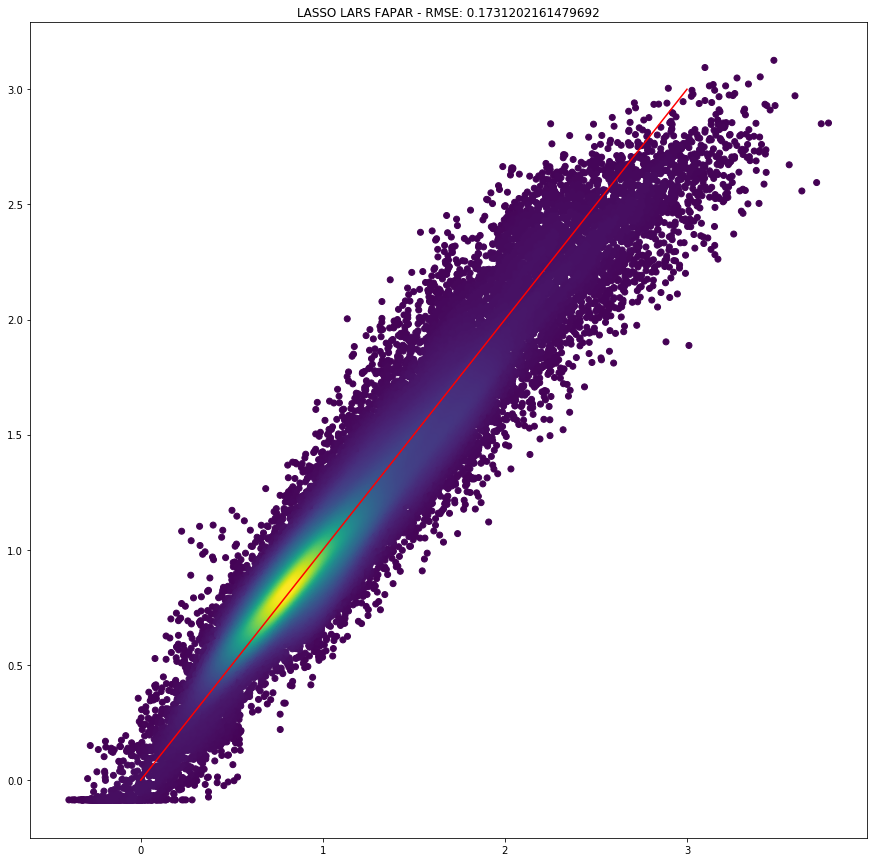

In [435]:
a_tf_LAI = numpy.linspace(0, 3, 1000)

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_tf_LAI))

In [436]:
LAI_model.get_weights()

[array([[-0.9140189 ,  0.01644898, -1.019952  ,  0.4426594 ,  0.8795708 ],
        [ 0.12638026,  0.91065484, -0.7558733 , -0.25476006,  0.34897125],
        [-0.3588645 , -0.6534027 , -0.1218296 , -0.49629033, -1.0431739 ],
        [ 0.05629742,  0.64341086, -0.27605888,  0.23870468,  0.71973217],
        [ 0.7028408 , -0.70375675,  1.2888024 ,  0.32285422, -0.6898858 ]],
       dtype=float32),
 array([-0.7429095 ,  0.35183492,  1.7522622 ,  0.8395307 , -0.28825095],
       dtype=float32),
 array([[ 0.01006405,  0.61711574, -0.38722363],
        [-0.61176974,  0.42289633, -0.18938172],
        [ 1.170335  ,  1.4767487 , -0.45758134],
        [ 0.19146417,  1.7094882 , -0.547092  ],
        [-0.67441434,  0.46035525, -0.52110016]], dtype=float32),
 array([-0.31921914,  0.000753  ,  0.        ], dtype=float32),
 array([[-0.62552303],
        [ 0.5217936 ],
        [-0.93091357]], dtype=float32),
 array([-0.08637273], dtype=float32)]

In [155]:
import math

In [156]:
def elu(x):
    return x if x>=0 else (math.exp(x)-1)

In [157]:
def softplus(x):
    return math.log(math.exp(x)+1)

In [158]:
def softsign(x):
    return x/(abs(x)+1)

In [159]:
def relu(x):
    return max(x, 0.0)

In [160]:
def tanh(x):
    return (math.exp(2*x)-1)/(math.exp(2*x)+1)

In [161]:
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [162]:
elu = numpy.vectorize(elu)
softplus = numpy.vectorize(softplus)
softsign = numpy.vectorize(softsign)
relu = numpy.vectorize(relu)
tanh = numpy.vectorize(tanh)
sigmoid = numpy.vectorize(sigmoid)

In [163]:
activation_functions = {"elu": elu, "softplus": softplus, "softsign": softsign, "relu": relu, "tanh": tanh, "sigmoid": sigmoid}

In [164]:
def apply_nnet(inputs, keras_model):
    
    for layer in keras_model.layers:
        layer_weights = layer.get_weights()
        node_weights = layer_weights[0]
        bias = layer_weights[1]
        
        inputs = inputs.dot(node_weights)+bias
        
        activation_function = layer.get_config()["activation"]
        if(activation_function != "linear"):
            activation_function = activation_functions[activation_function]
            
            inputs = activation_function(inputs)
            
    return inputs

In [165]:
row = 17023
inputs = X.iloc[row, :].to_numpy()
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(apply_nnet(inputs, LAI_model)[0])
print(y.iloc[row])

0.88467276
0.8846728641327264
0.9579716324806212


In [437]:
ee.Initialize()

In [438]:
def nnet_to_ee(keras_model):
    neural_net = ee.List([])
    for layer in keras_model.layers:
        layer_info = layer.get_config()
        num_nodes = layer_info["units"]
        activation = layer_info["activation"]
        
        layer_weights = layer.get_weights()[0].transpose()
        layer_bias = layer.get_weights()[1].tolist()
        
        nodes = [ee.ImageCollection([ee.Image(weight) for weight in node.tolist()]).toBands() for node in layer_weights]
        node_collection = ee.ImageCollection(ee.List([ee.Image(nodes[i]).set({"bias": layer_bias[i]}) for i in range(num_nodes)])).set({"activation": activation})
        neural_net = neural_net.add(node_collection)
    
    return neural_net

In [439]:
neural_net = nnet_to_ee(LAI_model)

In [446]:
# Defining all of the activation functions for image structures in Earth Engine
def linear(x):
    return ee.Image(x)

def elu(x):
    return ee.ImageCollection([x.mask(x.gte(0)), x.mask(x.lt(0)).exp().subtract(1)]).mosaic()

def softplus(x):
    return x.exp().add(1).log()

def softsign(x):
    return x.divide(x.abs().add(1))

def relu(x):
    return x.max(0.0)

def tanh(x):
    return x.multiply(2).exp().subtract(1).divide(x.multiply(2).exp().add(1))

def sigmoid(x):
    return x.exp().pow(-1).add(1).pow(-1)

In [447]:
# The following function applies a layer in the neural network as parsed in the parse_layer function to an input image with the selected features, and response.
# To fully apply the neural network we apply this function using the .iterate() method in Earth Engine on the input image in place of a loop
def apply_nnet(layer, inputs):
    layer = ee.ImageCollection(layer)
    inputs = ee.Image(inputs)
    
    activation = layer.getString("activation")

    def apply_node(node):
        node = ee.Image(node)
        bias = node.getNumber("bias")
        
        # Multiply by the weights of the node and add the bias of the node
        result = inputs.multiply(node).reduce(ee.Reducer.sum()).add(bias)
        # For now we can only apply the softsign activation function if the activation property of the layer is not "linear"
        return ee.Algorithms.If(activation.compareTo("linear"), relu(result), result)
    
    node_outputs = layer.map(apply_node).toBands()
    
    return node_outputs;

In [1071]:
validation_data = inputImage.select("LAI")
nnet_inputs = scaledImage.select(selected_features)
prediction_data = ee.Image(neural_net.iterate(apply_nnet, nnet_inputs)).rename("LAI_predicted")

In [449]:
import folium

In [ ]:
mapIdDict = prediction_data.getMapId()
MAP = folium.Map(location=[49.7, -97.9])
folium.TileLayer(
    tiles=mapIdDict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Predicted LAI',
  ).add_to(map)
MAP.add_child(folium.LayerControl())
MAP